# Functions to preprocess data
Requires a pandas dataframe as input
Provides a pandas dataframe as output

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [2]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

df original shape:  (92834, 3)


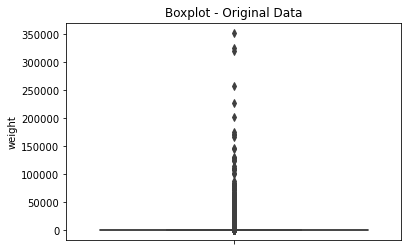

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (89545, 3)


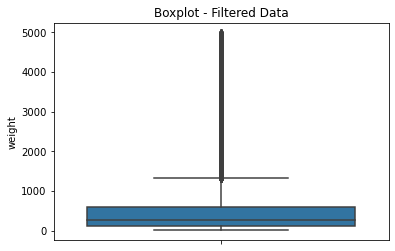

filtered data - stats:
count    89545.000000
mean       509.468792
std        696.317684
min          5.000000
25%        112.000000
50%        260.000000
75%        594.000000
max       4991.000000
Name: weight, dtype: float64


% of removed records: 0.0354


In [3]:
weights_filtered = remove_extreme_weights(weights_df,5,5000)

In [4]:
#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


In [5]:
weights_for_model = remove_users_lowcount(weights_filtered,20)

df original shape:  (89545, 3)
unique users:  1875
users with less than 20 artists: 41
unique users after removal:  1834
df new shape:  (89228, 3)
% of removed records: 0.0035


In [6]:
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top sum of weight (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    #input dataset info
    print(f"input data shape: {df.shape}")

    artists_group = df.groupby('artistID').agg({'weight': ['sum']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    
    artists_group['sum'].plot()
    plt.tick_params(labelbottom = False)
    plt.title('Long tail distribution of Artist sum of weights')
    plt.ylabel('sum of weights')
    plt.show()
    
    artists_group = artists_group.sort_values(by='sum',ascending=False)
    top_list = artists_group.head(10).index
    print('top 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['sum'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['sum'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['sum']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    
    artists_group['sum'].plot()
    plt.tick_params(labelbottom = False)
    plt.title('Distribution of Artist sum of weights - Filtered Dataset')
    plt.ylabel('sum of weights')
    plt.show()
    
    artists_group = artists_group.sort_values(by='sum',ascending=False)
    top_list = artists_group.head(10).index
    print('top 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df

input data shape: (89228, 3)


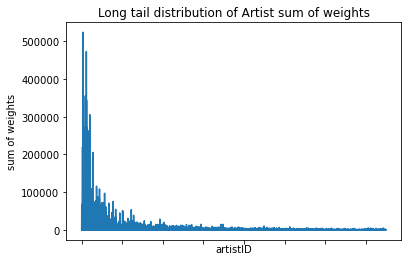

top 10 artists: 
61                Madonna
83              Lady Gaga
148             Radiohead
221           The Beatles
282               Rihanna
283        Britney Spears
286    Christina Aguilera
294            Katy Perry
327         Avril Lavigne
492              Paramore
Name: name, dtype: object


total removed artists: 171


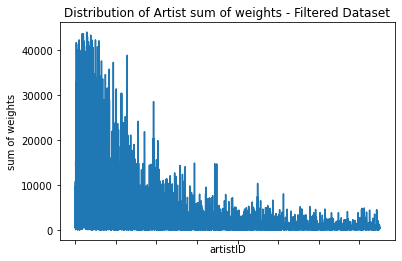

top 10 artists - filtered dataset: 
232       Massive Attack
410         The National
417       Bat for Lashes
482     Three Days Grace
491           Papa Roach
697               The xx
709               R.E.M.
739     Boards of Canada
942             Bon Jovi
1234                Mika
Name: name, dtype: object


filtered dataset shape: (62252, 3)
% of removed records: 0.3023


In [7]:
weights_filtered = remove_popular_artists(weights_for_model,artist_df,0.01)

In [8]:
#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df


df original shape:  (62252, 3)


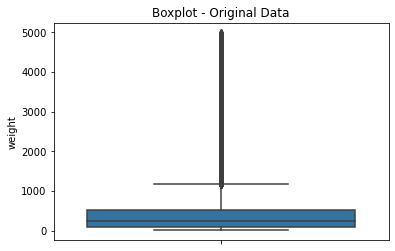

df scaled shape:  (62252, 3)


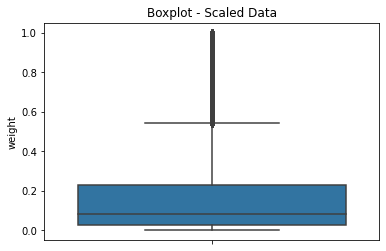

In [9]:
weights_scaled = scale_weight_by_user(weights_filtered)

In [10]:
def train_test_split(df,sample_size):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    sample_size must be smaller than total artist count per user!!!
    '''  
    print(f"input data shape: {df.shape}")

    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")

    return train, test

In [11]:
train, test = train_test_split(weights_scaled,5)

input data shape: (62252, 3)
train set shape: (53082, 3)
test set shape: (9170, 3)
